In [1]:
%matplotlib inline

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-u68bbimo because the default path (/home/dforeman/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
import numpy as np
import scipy.stats
from scipy.ndimage import gaussian_filter
from scipy.interpolate import RegularGridInterpolator

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from astropy.io import fits

import kepler
import corner

In [3]:
plt.style.use("default")
plt.rcParams["savefig.dpi"] = 100
plt.rcParams["figure.dpi"] = 100
plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Liberation Sans"]
plt.rcParams["font.cursive"] = ["Liberation Sans"]
plt.rcParams["mathtext.fontset"] = "custom"
get_ipython().magic('config InlineBackend.figure_format = "retina"')

In [4]:
with fits.open("/data/rv_uncertainty_grid.fits") as f:
    hdr = f[0].header
    mu = f[1].data
    sigma = f[2].data
    
color_bins = np.linspace(hdr["MIN_COL"], hdr["MAX_COL"], hdr["NUM_COL"] + 1)
mag_bins = np.linspace(hdr["MIN_MAG"], hdr["MAX_MAG"], hdr["NUM_MAG"] + 1)
ivar = 1.0 / sigma ** 2

ln_sigma_model = gaussian_filter(np.mean(mu, axis=-1), (1, 0.8))

interp = RegularGridInterpolator(
    [0.5 * (mag_bins[1:] + mag_bins[:-1]), 0.5 * (color_bins[1:] + color_bins[:-1])],
    ln_sigma_model,
    bounds_error=False,
    fill_value=None
)

In [5]:
with fits.open("/data/gold_sample.fits") as f:
    apogee_data = f[1].data

apogee_data = apogee_data[(apogee_data["phot_g_mean_mag"] < 12) & np.isfinite(apogee_data["radial_velocity_error"])]
max_nb_transits = apogee_data["rv_nb_transits"].max()

In [6]:
np.random.seed(723)
n_samp = 1000000

# Simulate transit times by sampling target_num_transit samples from the scanning law
t = np.random.uniform(0, 668, (max_nb_transits, n_samp))

eps = 0.02 * np.random.randn(n_samp)

# Sample many parameters from the prior
log_period = np.random.uniform(np.log10(1.0), np.log10(800.0), n_samp)
phase = np.random.uniform(-np.pi, np.pi, n_samp)
log_semiamp = np.random.uniform(np.log(0.1), np.log(100.0), n_samp)
ecc = scipy.stats.beta(0.867, 3.03).rvs(n_samp)
omega = np.random.uniform(-np.pi, np.pi, n_samp)

# Compute the Keplerian model
cosw = np.cos(omega)
sinw = np.sin(omega)
M = 2 * np.pi * t * 10 ** -log_period[None, :] + phase[None, :]
_, cosf, sinf = kepler.kepler(M, ecc[None, :] + np.zeros_like(M))
mod = np.exp(log_semiamp[None, :]) * (cosw[None, :] * (ecc[None, :] + cosf) - sinw[None, :] * sinf)

In [7]:
lam = np.zeros((max_nb_transits + 1, n_samp))
for n in range(2, max_nb_transits + 1):
    m = mod[:n + 1]
    lam[n] = np.sum((m - np.mean(m, axis=0)[None, :])**2, axis=0)

In [8]:
from tqdm import tqdm

res = np.empty((len(apogee_data), 3))
for n, target in tqdm(enumerate(apogee_data), total=len(apogee_data)):
    target_num_transit = target["rv_nb_transits"]
    target_sample_variance = 2 * target_num_transit * (target["radial_velocity_error"] ** 2 - 0.11 ** 2) / np.pi
    log_sigma = interp([target["phot_g_mean_mag"], target["bp_rp"]])
    ivar = np.exp(-2 * (log_sigma + eps))
    target_lam = lam[target_num_transit] * ivar
    ncx2 = scipy.stats.ncx2(df=target_num_transit, nc=target_lam)
    log_weight = ncx2.logpdf((target_num_transit - 1) * target_sample_variance * ivar)
    res[n] = corner.quantile(np.exp(log_semiamp), [0.16, 0.5, 0.84], weights=np.exp(log_weight - log_weight.max()))

100%|██████████| 193/193 [01:59<00:00,  1.62it/s]


In [9]:
sigma = np.exp(interp(np.array([apogee_data["phot_g_mean_mag"], apogee_data["bp_rp"]]).T))
snr = res[:, 1] / sigma

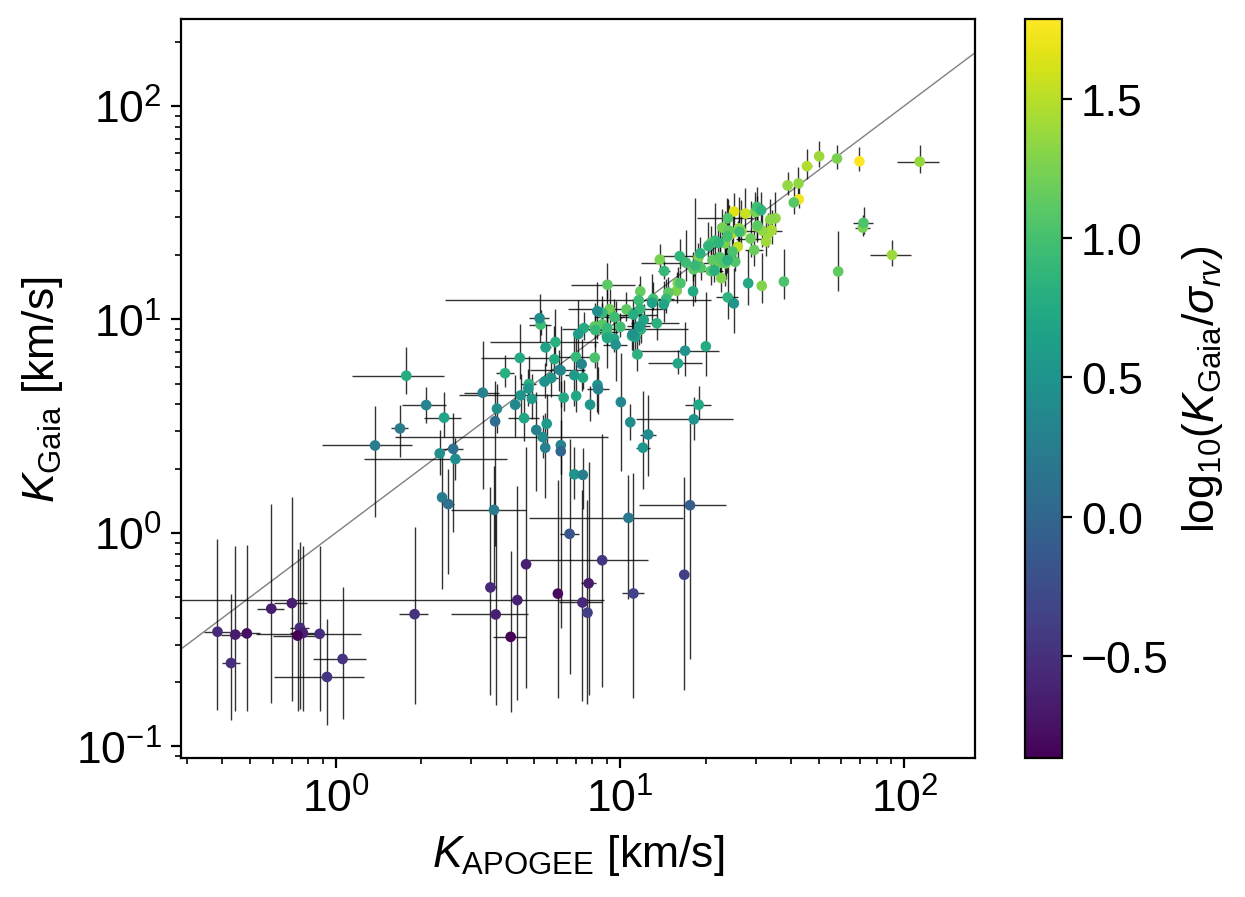

In [21]:
inds = np.argsort(snr)[::-1]
# inds = inds[snr[inds] > 1]
plt.errorbar(apogee_data["MAP_K"][inds], res[inds, 1], xerr=apogee_data["MAP_K_err"][inds], yerr=np.diff(res, axis=1)[inds].T, fmt=",k", alpha=0.8, lw=0.5)
plt.scatter(apogee_data["MAP_K"][inds], res[inds, 1], c=np.log10(snr)[inds], s=8, zorder=10)
plt.xscale("log")
plt.yscale("log")
xlim = plt.xlim()
plt.plot(xlim, xlim, "k", lw=0.5, alpha=0.5)
plt.xlim(xlim)
plt.xlabel(r"$K_\mathrm{APOGEE}$ [km/s]")
plt.ylabel(r"$K_\mathrm{Gaia}$ [km/s]")
plt.colorbar(label=r"$\log_{10} (K_\mathrm{Gaia} / \sigma_{rv})$");